In [480]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [481]:
water_level_url = "GLHYD_data_metric.csv"
evaporation_url = "evaporation-ont.csv"
precipitation_url = "prc_ont_lake_mon.csv"
runoff_url = "runoff-ont.csv"


water_level_df = pd.read_csv(water_level_url)
evaporation_df = pd.read_csv(evaporation_url)
precipitation_df = pd.read_csv(precipitation_url)
runoff_df = pd.read_csv(runoff_url)


## Water Level Preprocessing

In [482]:


water_level_df = water_level_df.iloc[11:, :] # Remove notes from dataframe
water_level_df.columns = water_level_df.iloc[0,:] # rename columns
water_level_df = water_level_df.reset_index().drop(columns = "index") # reset index
water_level_df.columns.name = "" # Rename index column
water_level_df = water_level_df.iloc[1:, :] # Ensure "year" col is numeric
water_level_df["year"] = water_level_df["year"].astype(int) # convert "year" col to integers
water_level_df = water_level_df[water_level_df['year'] >= 1950].reset_index().drop(columns= "index") #subset data so it starts at 1940
water_level_df['month'] = water_level_df['month'].map({'jan' : 1,
                                                        'feb' : 2,
                                                        'mar' : 3,
                                                        'apr' : 4,
                                                        'may' : 5,
                                                        'jun' : 6,
                                                        'jul' : 7,
                                                        'aug' : 8,
                                                        'sep' : 9,
                                                        'oct' : 10,
                                                        'nov' : 11,
                                                        'dec' : 12
                                                        }) # Rename months to corresponding integers
water_level_df = pd.melt(frame = water_level_df,
                         id_vars= ["month", "year"],
                         value_vars= ["Superior", "Michigan-Huron", "St. Clair", "Erie", "Ontario"],
                         var_name= "lake",
                         value_name= "water level"
                         ) # Make each lake a value in new column "lake"
water_level_df = water_level_df[water_level_df['year'] <= 2020].reset_index().drop(columns= "index")
water_level_df.shape


(4260, 4)

## Evaporation Preprocessing

In [483]:
evaporation_df = pd.melt(frame = evaporation_df,
                         id_vars= "YYYY",
                         value_vars= evaporation_df.columns[1:],
                         var_name= "month",
                         value_name= "evaporation") # Make Months a value in the DF

evaporation_df = evaporation_df.rename(columns= {"YYYY" : "year"}) # Change name of year column

# Since we are assuming that evaporation is constant for all the lakes, we are going to extend this DF so that each lake as the same evaporation.

evaporation_df = pd.concat([evaporation_df] * 5, ignore_index= True)

evaporation_df.head()



,year,month,evaporation
0,1950,Jan,101.10
1,1951,Jan,89.08
2,1952,Jan,82.57
3,1953,Jan,89.67
4,1954,Jan,125.15


## Runoff Preprocessing

In [484]:
runoff_df = runoff_df[runoff_df["Year"] >= 1950]
runoff_df = runoff_df.reset_index().drop(columns = ["index", runoff_df.columns[5]])
runoff_df = pd.concat([runoff_df] * 5, ignore_index= True)
runoff_df

,Year,Mon,Flow,%gauged,#gauges
0,1950,1,1612.18,45.90,10.00
1,1950,2,951.42,45.90,10.00
2,1950,3,2100.59,45.90,10.00
3,1950,4,3057.59,45.90,10.00
4,1950,5,868.02,45.90,10.00
...,...,...,...,...,...
4255,2020,8,270.27,42.64,11.00
4256,2020,9,-999.99,-999.99,-999.99
4257,2020,10,-999.99,-999.99,-999.99
4258,2020,11,-999.99,-999.99,-999.99


## Precipitation Preprocessing

In [485]:
precipitation_df = pd.melt(frame = precipitation_df,
                           id_vars= "YYYY",
                           value_vars= precipitation_df.columns[1:],
                           var_name= "month",
                           value_name= "precipitation") # Turn Month into col values
precipitation_df = precipitation_df.rename(columns= {"YYYY" : "year"}) # rename year column
precipitation_df = precipitation_df[(precipitation_df["year"] >= 1950) & (precipitation_df["year"] <= 2020)] #subset df for 1950 - 2020
precipitation_df = precipitation_df.reset_index().drop(columns = "index")
precipitation_df = pd.concat([precipitation_df] * 5, ignore_index= True)
precipitation_df.shape



(4260, 3)

# New DataFrame

Water level, evaporation, runoff, precipiation

In [488]:
df = pd.concat([water_level_df, evaporation_df, runoff_df, precipitation_df], axis = 1)
df = df.loc[:, ~df.columns.duplicated()]
df = df.drop(columns= "Mon").reset_index().drop(columns = ["index", "Year"])
df = df.rename(columns= {df.columns[5] : "flow"})
df.head()



,month,year,lake,water level,evaporation,flow,%gauged,#gauges,precipitation
0,1,1950,Superior,183.42,101.10,1612.18,45.9,10.0,106.56
1,2,1950,Superior,183.37,89.08,951.42,45.9,10.0,68.37
2,3,1950,Superior,183.33,82.57,2100.59,45.9,10.0,66.2
3,4,1950,Superior,183.37,89.67,3057.59,45.9,10.0,62.78
4,5,1950,Superior,183.57,125.15,868.02,45.9,10.0,59.98


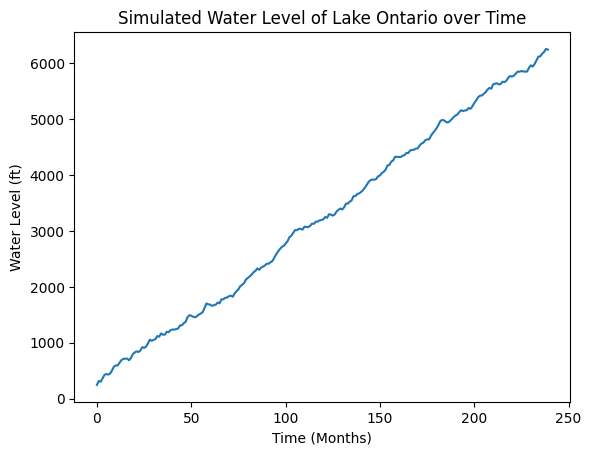

In [489]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants for each factor (these would need to be calibrated)
alpha = 0.5   # Precipitation effect
beta = 0.3    # Runoff effect
gamma = 0.2   # Inflow from other lakes effect
delta = 0.4   # Evaporation effect
eta = 0.3     # Outflow effect

# Example time range (monthly data)
time_steps = 240  # Simulate for 20 years (240 months)

# Initialize arrays for variables (for simplicity, let's assume some initial values)
precipitation = np.random.uniform(0, 2, time_steps)  # Random precipitation values in inches
runoff = np.random.uniform(0, 1, time_steps)  # Random runoff values in cubic feet per second
inflow_lakes = np.random.uniform(100, 500, time_steps)  # Random inflow from other lakes
evaporation = np.random.uniform(0.1, 0.5, time_steps)  # Random evaporation values in inches
outflow = np.random.uniform(50, 200, time_steps)  # Random outflow values

# Initialize water level
H = np.zeros(time_steps)
H[0] = 245  # Assume initial water level is 245 ft

# Time-stepping loop to calculate water level over time
for t in range(1, time_steps):
    delta_H = (alpha * precipitation[t] + beta * runoff[t] + gamma * inflow_lakes[t] - 
               delta * evaporation[t] - eta * outflow[t])
    H[t] = H[t-1] + delta_H  # Update water level

# Plot the results
plt.plot(H)
plt.xlabel('Time (Months)')
plt.ylabel('Water Level (ft)')
plt.title('Simulated Water Level of Lake Ontario over Time')
plt.show()
